In [1]:
!pip install neuralprophet

     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 81kB 7.8MB/s 
     |████████████████████████████████| 748.8MB 18kB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.6.0 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.6.0 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training


In [88]:
import pandas as pd
from torch.nn import MSELoss
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed 
set_random_seed(0)

In [38]:
df = pd.read_csv('../dataset/Rainfall 2010-2020/rainfall_dataset.csv')
df

,DISTRICTS,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,YEAR
0,BAGALKOTE,0.0,1.9,0.4,39.2,81.0,74.9,77.6,107.0,57.1,90.4,0.0,0.0,2011
1,BENGALURU RURAL,0.0,2.5,2.7,88.7,97.5,47.4,106.1,230.6,61.9,130.2,26.7,5.2,2011
2,BENGALURU URBAN,0.0,18.2,2.0,157.8,139.1,54.5,92.6,237.5,89.3,170.8,64.8,5.9,2011
3,BELAGAVI,0.0,4.4,0.0,49.2,54.6,180.3,157.8,164.2,111.5,138.7,3.3,0.0,2011
4,BELLARY,0.0,0.5,1.2,44.4,65.7,75.8,95.0,87.2,25.9,69.0,8.9,0.0,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,YADGIR,0.0,0.0,0.0,15.7,21.9,82.5,138.2,70.7,181.1,67.4,11.2,0.9,2019
270,MYSURU,0.0,4.3,19.9,50.0,128.4,72.7,124.2,138.5,140.4,97.1,36.0,14.7,2020
271,HASSAN,0.2,0.0,13.2,47.2,161.0,111.3,177.3,225.0,175.9,155.4,26.9,16.4,2020
272,KODAGU,0.0,0.0,16.3,113.2,201.8,412.2,436.9,974.9,521.1,178.7,24.1,9.9,2020


In [39]:
def reorder(df):
    df = df.transpose()
    year = df.loc['YEAR'].values[0]
    df.drop(index=['DISTRICTS', 'YEAR'], inplace=True)
    df.reset_index(inplace=True)
    df.columns = ['MONTH', 'RAINFALL']
    df.sort_values(by=['MONTH'])
    return df

In [40]:
mod_df = df[df['DISTRICTS']=='KODAGU'].groupby('YEAR').apply(reorder).reset_index()
mod_df

,YEAR,level_1,MONTH,RAINFALL
0,2011,0,JAN,0.7
1,2011,1,FEB,22.2
2,2011,2,MAR,13.2
3,2011,3,APR,138.5
4,2011,4,MAY,107.5
...,...,...,...,...
115,2020,7,AUG,974.9
116,2020,8,SEP,521.1
117,2020,9,OCT,178.7
118,2020,10,NOV,24.1


In [41]:
mod_df['level_1'] += 1
mod_df['level_2'] = ["%02d" % x for x in mod_df['level_1'].values]
mod_df

,YEAR,level_1,MONTH,RAINFALL,level_2
0,2011,1,JAN,0.7,01
1,2011,2,FEB,22.2,02
2,2011,3,MAR,13.2,03
3,2011,4,APR,138.5,04
4,2011,5,MAY,107.5,05
...,...,...,...,...,...
115,2020,8,AUG,974.9,08
116,2020,9,SEP,521.1,09
117,2020,10,OCT,178.7,10
118,2020,11,NOV,24.1,11


In [42]:
mod_df['ds'] = mod_df['YEAR'].astype(str) + '-' + mod_df['level_2']
mod_df.rename(columns={'RAINFALL': 'y'}, inplace=True)
mod_df

,YEAR,level_1,MONTH,y,level_2,ds
0,2011,1,JAN,0.7,01,2011-01
1,2011,2,FEB,22.2,02,2011-02
2,2011,3,MAR,13.2,03,2011-03
3,2011,4,APR,138.5,04,2011-04
4,2011,5,MAY,107.5,05,2011-05
...,...,...,...,...,...,...
115,2020,8,AUG,974.9,08,2020-08
116,2020,9,SEP,521.1,09,2020-09
117,2020,10,OCT,178.7,10,2020-10
118,2020,11,NOV,24.1,11,2020-11


In [43]:
mod_df = mod_df[['ds', 'y']]
mod_df.head()

,ds,y
0,2011-01,0.7
1,2011-02,22.2
2,2011-03,13.2
3,2011-04,138.5
4,2011-05,107.5


In [44]:
train_df = mod_df[~mod_df['ds'].str.startswith('2020')]
test_df = mod_df[mod_df['ds'].str.startswith('2020')]

del mod_df
train_df.shape, test_df.shape

((108, 2), (12, 2))

In [90]:
m = NeuralProphet(epochs=4000, batch_size=4, num_hidden_layers=2, d_hidden=3, loss_func=MSELoss(), normalize=False)
metrics = m.fit(train_df, validate_each_epoch=True, freq="M")

ERROR: nprophet.df_utils - get_normalization_params: Normalization False not defined.
INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-02
Epoch[4000/4000]: 100%|██████████| 4000/4000 [01:55<00:00, 34.50it/s, MSELoss=4.41e+4, MAE=130, RegLoss=0, MAE_val=261, MSELoss_val=1.73e+5]


In [91]:
future = m.make_future_dataframe(train_df, periods=12)
forecast = m.predict(future)

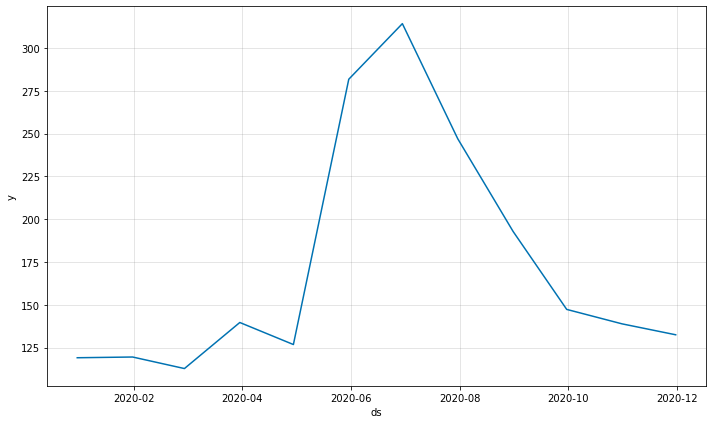

In [92]:
forecasts_plot = m.plot(forecast)

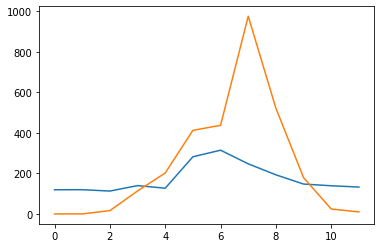

In [93]:
import matplotlib.pyplot as plt
# forecasts_plot

plt.plot(forecast['yhat1'].values)
plt.plot(test_df['y'].values)

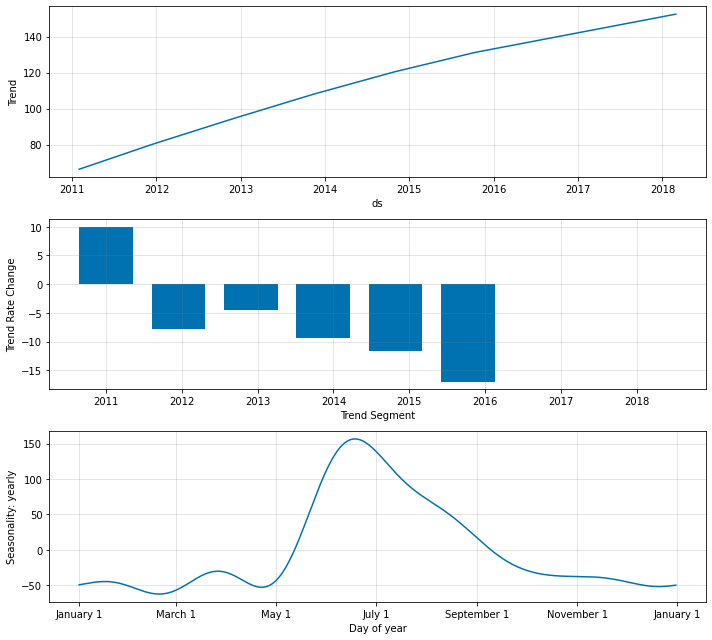

In [94]:
fig_param = m.plot_parameters()

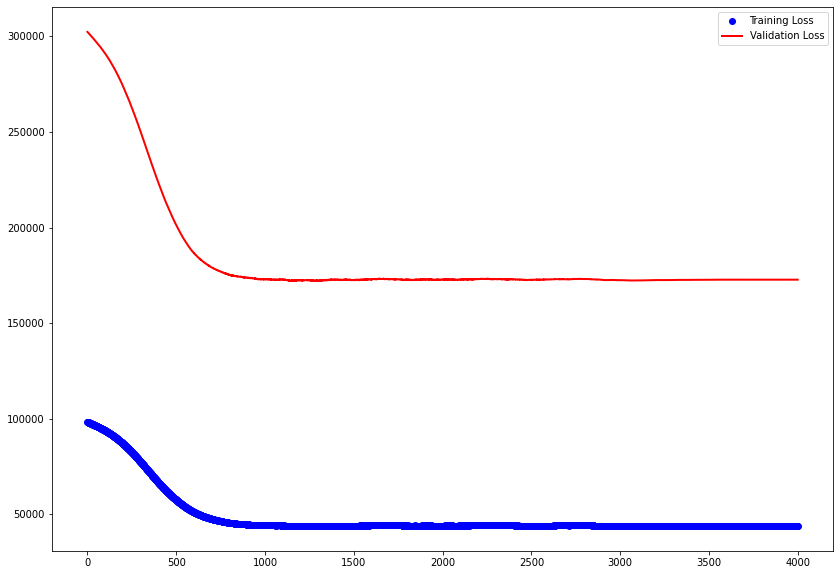

In [96]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(metrics["MSELoss"], 'ob', linewidth=6, label="Training Loss")  
ax.plot(metrics["MSELoss_val"], '-r', linewidth=2, label="Validation Loss")
plt.legend()
plt.show()